# SoftActorCritifcの制度検証

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=faea50e9247de12a24eb0cb2911a5b3656879b72ebf28cb45ebf508c022e9814
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 25.9 GB  | Proc size: 95.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [3]:
%cd /content/drive/MyDrive/knowledge/deep_reinforcement_learning/soft_actor_critic/

/content/drive/MyDrive/knowledge/deep_reinforcement_learning/soft_actor_critic


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 7.5 MB/s 
     |████████████████████████████████| 9.9 MB 61.1 MB/s 
     |████████████████████████████████| 696 kB 59.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 285 kB 81.4 MB/s 
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793151 sha256=a66d7da27c7534d123fb9b5eafb7af9c4c959d8ad09014c99a64cdf44b202453
  Stored in directory: /root/.cache/pip/wheels/18/0e/54/63d9f3d16ddf0fec1622e90d28140df5e6016bcf8ea920037d
Successfully built gym
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Su

In [19]:
from pathlib import Path
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gym
from agents import ActorCriticModel, SoftActorCriticModel
from memories import ReplayMemory

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## パラメータの設定

In [21]:
gym_game_name = 'Pendulum-v1'

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
result_dir_path = Path('result')
model_dir_path = Path('model')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

## モデルの精度検証

In [24]:
def train_agent(env, args, device, flag_sac=0, epochs=300):

    if flag_sac == 1:
        agent = SoftActorCriticModel(
            state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0],
            action_scale=env.action_space.high[0], args=args, device=device
        )
    else:
        agent = ActorCriticModel(
            state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0],
            action_scale=env.action_space.high[0], args=args, device=device
        )

    memory = ReplayMemory(args['memory_size'])

    episode_reward_list = []
    eval_reward_list = []

    n_steps = 0
    n_update = 0
    for i_episode in range(1, epochs + 1):

        episode_reward = 0
        done = False
        state = env.reset()

        while not done:
            
            if args['start_steps'] > n_steps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state)

            if len(memory) > args['batch_size']:
                agent.update_parameters(memory, args['batch_size'], n_update)
                n_update += 1

            next_state, reward, done, _ = env.step(action)
            n_steps += 1
            episode_reward += reward

            memory.push(state=state, action=action, reward=reward, next_state=next_state, mask=float(not done))

            state = next_state

        episode_reward_list.append(episode_reward)

        if i_episode % args['eval_interval'] == 0:
            avg_reward = 0.
            for _  in range(args['eval_interval']):
                state = env.reset()
                episode_reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        action = agent.select_action(state, evaluate=True)
                    next_state, reward, done, _ = env.step(action)
                    episode_reward += reward
                    state = next_state
                avg_reward += episode_reward
            avg_reward /= args['eval_interval']
            eval_reward_list.append(avg_reward)

    return eval_reward_list, agent

In [25]:
args = {
    'gamma': 0.99,
    'tau': 0.005,
    'alpha': 0.2,
    'seed': 123456,
    'batch_size': 256,
    'hidden_size': 256,
    'start_steps': 1000,
    'target_update_interval': 1,
    'memory_size': 100000,
    'epochs': 100,
    'eval_interval': 10
}

In [26]:
env = gym.make(gym_game_name)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [13]:
n_experiment = 10
epochs = 300
results = pd.DataFrame()
for flag_sac in [0, 1]:
    for i in range(1, n_experiment + 1):
        start_time = time.time()
        eval_reward_list, agent = train_agent(
            env=env, args=args, device=device, flag_sac=flag_sac, epochs=epochs
        )
        results = pd.concat([
            results,
            pd.DataFrame({
                'agent_type': ['soft_actor_critic' if flag_sac == 1 else 'actor_critic'] * len(eval_reward_list),
                'loop': [i] * len(eval_reward_list),
                'n_step': np.arange(1, len(eval_reward_list) + 1),
                'reward': eval_reward_list
            })
        ], axis=0)
        elapsed_time = time.time() - start_time
        print('[Done] Agent Model: {}, Num Experiment: {}, Time: {:.0f}s'.format(
            'SoftActorCritic' if flag_sac == 1 else 'ActorCritic', i, elapsed_time
        ))
        torch.save(agent.actor_net.to('cpu').state_dict(), model_dir_path.joinpath(f'{gym_game_name}_actor_{flag_sac}_{i}.pth'))
results.to_csv(result_dir_path.joinpath(f'{gym_game_name}_actor_critic_vs_sac.csv'), index=False)

[Done] Agent Model: ActorCritic, Num Experiment: 1, Time: 448s
[Done] Agent Model: ActorCritic, Num Experiment: 2, Time: 439s
[Done] Agent Model: ActorCritic, Num Experiment: 3, Time: 437s
[Done] Agent Model: ActorCritic, Num Experiment: 4, Time: 435s
[Done] Agent Model: ActorCritic, Num Experiment: 5, Time: 435s
[Done] Agent Model: ActorCritic, Num Experiment: 6, Time: 434s
[Done] Agent Model: ActorCritic, Num Experiment: 7, Time: 434s
[Done] Agent Model: ActorCritic, Num Experiment: 8, Time: 433s
[Done] Agent Model: ActorCritic, Num Experiment: 9, Time: 434s
[Done] Agent Model: ActorCritic, Num Experiment: 10, Time: 433s
[Done] Agent Model: SoftActorCritic, Num Experiment: 1, Time: 649s
[Done] Agent Model: SoftActorCritic, Num Experiment: 2, Time: 653s
[Done] Agent Model: SoftActorCritic, Num Experiment: 3, Time: 653s
[Done] Agent Model: SoftActorCritic, Num Experiment: 4, Time: 651s
[Done] Agent Model: SoftActorCritic, Num Experiment: 5, Time: 652s
[Done] Agent Model: SoftActorCriti

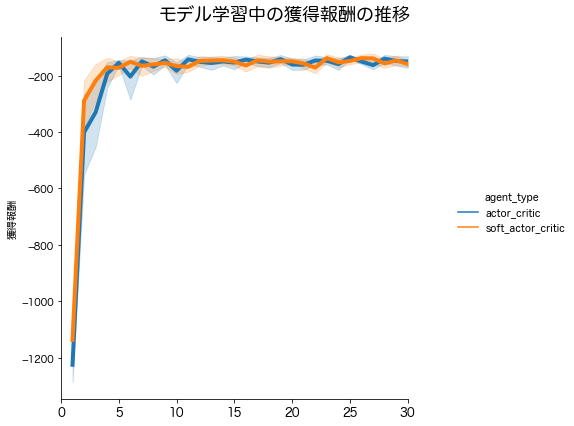

In [43]:
plot_data = pd.read_csv(result_dir_path.joinpath(f'{gym_game_name}_actor_critic_vs_sac.csv'))
figsize = (8, 6)
g = sns.relplot(data=plot_data, x='n_step', y='reward', hue='agent_type', kind='line', lw=4)
g.fig.suptitle('モデル学習中の獲得報酬の推移', fontsize=18, weight='bold')
g.fig.set_facecolor('white')
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
g.set_axis_labels('', '獲得報酬')
g.set_xticklabels(fontsize=12)
g.set(xlim=[0, plot_data['n_step'].max()])
g.tight_layout()
g.savefig(result_dir_path.joinpath(f'{gym_game_name}_plot_actor_critic_vs_sac.png'), dpi=500)

### 学習済みモデルの比較

In [27]:
from models import ActorNet

In [21]:
n_play = 100
results = []
for flag_sac in [0, 1]:
    for model_num in range(1, n_experiment + 1):
        model_file_path = model_dir_path.joinpath(f'{gym_game_name}_actor_{flag_sac}_{model_num}.pth')
        actor_net = ActorNet(
            input_dim=env.observation_space.shape[0], output_dim=env.action_space.shape[0],
            hidden_size=args['hidden_size'], action_scale=env.action_space.high[0]
        ).to(device)
        actor_net.load_state_dict(torch.load(model_file_path))

        for loop_num in range(n_play):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    _, action = actor_net.sample(state)
                    action = action.cpu().detach().numpy().reshape(-1)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
            results.append([flag_sac, model_num, loop_num, episode_reward])
        print('End Model: {}, Num: {}'.format('SAC' if flag_sac == 1 else 'ActorCritic', model_num))

results = pd.DataFrame(results, columns=['flag_sac', 'model_num', 'loop_num', 'episode_reward'])
results.to_csv(result_dir_path.joinpath(f'{gym_game_name}_eval_sac_vs_actor_critic.csv'), index=False)

End Model: ActorCritic, Num: 1
End Model: ActorCritic, Num: 2
End Model: ActorCritic, Num: 3
End Model: ActorCritic, Num: 4
End Model: ActorCritic, Num: 5
End Model: ActorCritic, Num: 6
End Model: ActorCritic, Num: 7
End Model: ActorCritic, Num: 8
End Model: ActorCritic, Num: 9
End Model: ActorCritic, Num: 10
End Model: SAC, Num: 1
End Model: SAC, Num: 2
End Model: SAC, Num: 3
End Model: SAC, Num: 4
End Model: SAC, Num: 5
End Model: SAC, Num: 6
End Model: SAC, Num: 7
End Model: SAC, Num: 8
End Model: SAC, Num: 9
End Model: SAC, Num: 10


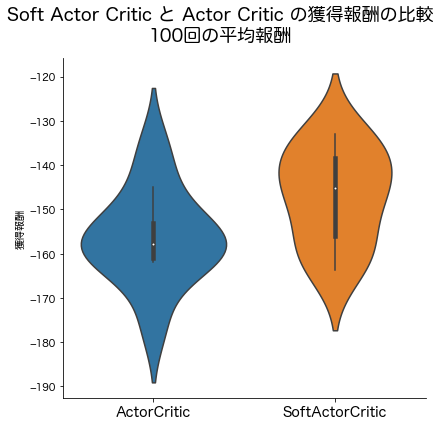

In [37]:
plot_data = pd.read_csv(result_dir_path.joinpath(f'{gym_game_name}_eval_sac_vs_actor_critic.csv'))
plot_data = plot_data.groupby(['flag_sac', 'model_num'])['episode_reward'].mean().reset_index().assign(
    model_name=lambda x: x.flag_sac.map(lambda y: 'SoftActorCritic' if y == 1 else 'ActorCritic')
)
figsize = (6, 6)
g = sns.catplot(data=plot_data, x='model_name', y='episode_reward', kind='violin')
g.fig.suptitle(f'Soft Actor Critic と Actor Critic の獲得報酬の比較\n{n_play}回の平均報酬', fontsize=18, weight='bold')
g.fig.set_facecolor('white')
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
g.set_axis_labels('', '獲得報酬')
g.set_xticklabels(fontsize=14)
g.tight_layout()
plt.savefig(result_dir_path.joinpath(f'{gym_game_name}_eval_reward_mean_sac_vs_actor_critic.png'), dpi=500)